# Práctica 3 - Quinta prueba

#### Pilar Navarro Ramírez

In [1]:
import pandas as pd

## Preprocesamiento

In [2]:
df_train=pd.read_csv("data/train.csv",na_values=[""])
df_test=pd.read_csv("data/test.csv",na_values=[""])

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4747 non-null   float64
 1   Nombre        4747 non-null   object 
 2   Ciudad        4747 non-null   object 
 3   Año           4747 non-null   float64
 4   Kilometros    4747 non-null   float64
 5   Combustible   4747 non-null   object 
 6   Tipo_marchas  4747 non-null   object 
 7   Mano          4747 non-null   object 
 8   Consumo       4746 non-null   object 
 9   Motor_CC      4718 non-null   object 
 10  Potencia      4644 non-null   object 
 11  Asientos      4713 non-null   float64
 12  Descuento     659 non-null    float64
 13  Precio_cat    4819 non-null   int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 527.2+ KB


In [4]:
df_train.columns = [col.lower() for col in df_train]
df_test.columns = [col.lower() for col in df_test]

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

del df_train["id"]
del df_test["id"]

### Tratamos los datos perdidos

In [5]:
from sklearn import impute

In [6]:
del df_train['descuento']
del df_test['descuento']

In [7]:
df_train_replaced=df_train.copy()
imputer=impute.SimpleImputer(strategy="most_frequent")
values = imputer.fit_transform([df_train_replaced.asientos.values])
df_train_replaced.asientos.update(pd.Series(values[0]))

In [8]:
df_train_replaced=df_train_replaced.dropna()
df_train=df_train.dropna()

Separamos el atributo a predecir del resto de atributos en el conjunto de entrenamiento.

In [9]:
cols = [col for col in df_train.columns if col not in ['precio_cat']]    
df_train, df_train_obj= df_train[cols], df_train['precio_cat']
df_train_replaced, df_train_obj_replaced= df_train_replaced[cols], df_train_replaced['precio_cat']

### 'Transformación' de variables categóricas a numéricas

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_num=df_train.copy()
df_train_num_rpl=df_train_replaced.copy()
df_test_num=df_test.copy()

for atributo in categorical:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    label = LabelEncoder().fit(data[atributo])
    df_train_num[atributo]=label.transform(df_train[atributo])
    df_train_num_rpl[atributo]=label.transform(df_train_replaced[atributo])
    df_test_num[atributo]=label.transform(df_test[atributo])

### Normalización de los datos

In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cols = [col for col in df_train_orig.columns if col not in ['precio_cat','id','descuento']]  
categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]

df_train_norm=df_train_num.copy()
df_train_norm_rpl=df_train_num_rpl.copy()
df_test_norm=df_test_num.copy()


for atributo in cols:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    if atributo in categorical:
        label = LabelEncoder().fit(data[atributo])
        data[atributo]=label.transform(data[atributo])
    scaler = MinMaxScaler().fit(data.values)
    train_values=df_train_num[atributo].values.reshape(-1,1)
    df_train_norm[atributo]=scaler.transform(train_values)
    train_values_rpl=df_train_num_rpl[atributo].values.reshape(-1,1)
    df_train_norm_rpl[atributo]=scaler.transform(train_values_rpl)
    test_values=df_test_num[atributo].values.reshape(-1,1)
    df_test_norm[atributo]=scaler.transform(test_values)
    

## Aplicación de los algoritmos

In [12]:
import numpy as np

from sklearn.model_selection import cross_val_score

def cross_validation(clf,x,y,mostrar=False):
    scores=cross_val_score(clf,x,y,scoring='accuracy',cv=5)
    accuracy=np.mean(scores)  
    if mostrar:
        print("Accuracy: ", accuracy)
    return accuracy

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

forest=RandomForestClassifier(random_state=10)
NN=MLPClassifier(random_state=10,max_iter=10000)
clfs=[forest,NN]

for clf in clfs:
    print("Datos normalizados con todos nulos eliminados: ")
    print(clf)
    cross_validation(clf, df_train_norm, df_train_obj,True)
    print("Datos normalizados con nulos en asientos reemplazados: ")
    print(clf)
    cross_validation(clf,df_train_norm_rpl,df_train_obj_replaced,True)

Datos normalizados con todos nulos eliminados: 
RandomForestClassifier(random_state=10)
Accuracy:  0.822791822721598
Datos normalizados con nulos en asientos reemplazados: 
RandomForestClassifier(random_state=10)
Accuracy:  0.8225264679620732
Datos normalizados con todos nulos eliminados: 
MLPClassifier(max_iter=10000, random_state=10)
Accuracy:  0.6995602372034957
Datos normalizados con nulos en asientos reemplazados: 
MLPClassifier(max_iter=10000, random_state=10)
Accuracy:  0.7510483924851032


### Configuración de los parámetros

##### Redes Neuronales

In [14]:
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier

def tune_layers(max_value):
    acc=[]
    for i in range(40,max_value,20):
        NN=MLPClassifier(hidden_layer_sizes=(i,i),random_state=10,max_iter=1000)
        acc.append(cross_validation(NN,df_train_norm,df_train_obj))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(40,max_value,20), acc)
    ax.set_title('Neural Network')
    ax.set_xlabel('Tamaño capas')
    ax.set_ylabel('Accuracy')
    plt.show()

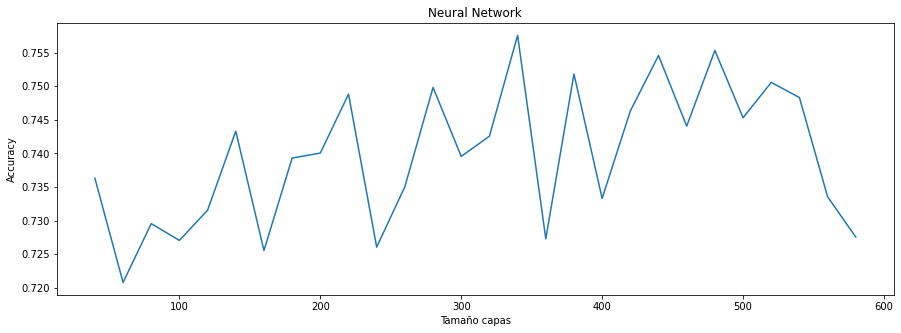

In [29]:
tune_layers(600)

In [17]:
NN=MLPClassifier(hidden_layer_sizes=(340,340),random_state=10,max_iter=1000)
cross_validation(NN, df_train_norm, df_train_obj,True)

Accuracy:  0.7575505617977528


0.7575505617977528

In [27]:
from sklearn.model_selection import GridSearchCV

mlp=MLPClassifier(random_state=10)
parameter_space = {
    'hidden_layer_sizes': [(200,100,100),(300,200,100),(200,100,50),(340,340)],
    'alpha': [0.001, 0.0003,0.0015,0.01,0.02,0.1,],
    'max_iter':[10000],
}

clf=GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(df_train_norm, df_train_obj)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.0003, 0.0015, 0.01, 0.02, 0.1],
                         'hidden_layer_sizes': [(200, 100, 100),
                                                (300, 200, 100), (200, 100, 50),
                                                (340, 340)],
                         'max_iter': [10000]})

In [29]:
print('Mejores parámetros: ', clf.best_params_)

Mejores parámetros:  {'alpha': 0.0015, 'hidden_layer_sizes': (300, 200, 100), 'max_iter': 10000}


In [21]:
NN=MLPClassifier(hidden_layer_sizes=(300,200,100),random_state=10,max_iter=1000,alpha=0.0015)
cross_validation(NN,df_train_norm,df_train_obj,True)

Accuracy:  0.7578021223470662


0.7578021223470662

In [22]:
mlp=MLPClassifier(random_state=10,max_iter=10000,early_stopping=True)
parameter_space = {
    'hidden_layer_sizes': [(400,300,200),(300,200,100),(300,200,300)],
    'alpha': [0.0015, 0.002,0.01,0.0005,0.0009,0.003],
}

clf=GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(df_train_norm, df_train_obj)

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                     random_state=10),
             n_jobs=-1,
             param_grid={'alpha': [0.0015, 0.002, 0.01, 0.0005, 0.0009, 0.003],
                         'hidden_layer_sizes': [(400, 300, 200),
                                                (300, 200, 100),
                                                (300, 200, 300)]})

In [23]:
print('Mejores parámetros: ', clf.best_params_)

Mejores parámetros:  {'alpha': 0.002, 'hidden_layer_sizes': (400, 300, 200)}


In [24]:
NN=MLPClassifier(hidden_layer_sizes=(400,300,200),random_state=10,max_iter=1000,alpha=0.002)
cross_validation(NN,df_train_norm,df_train_obj,True)

Accuracy:  0.7185546192259675


0.7185546192259675

### Aplicación al conjunto de test

In [ ]:
NN=MLPClassifier(hidden_layer_sizes=(300,200,100),random_state=10,max_iter=1000,alpha=0.0015)
NN.fit(df_train_norm,df_train_obj)
pred=NN.predict(df_test_norm)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_6.csv", index=False)